# **Christmas Challenge - Model Generation**

For this challenge we tried 4 different models:
- Keras RNN based on word prediction logics
- Keras RNN based on character prediction logics
- Textgenrnn model (Optimized RNN constructed by Max Woolf)
- GPT-2 Model (GPT2 Transformer developed by OpenAI)

Results
- The GPT-2 model performs better than the others, but still it is blackbox and does not permit a clear printing of testing parameter (example: difference between loss in testing & validation is implicity handle by the model) 
- Textgenrnn is a good tradeoff between simplicity and customization. It provides an optimized NN structure while handling checkpoint printing to track overfitting
- The two hand-made RNN provides an high customization level but do overfit to quickly without providing good performance metrics

### **Setup**

In [ ]:
# Tensorflow Libraries
%tensorflow_version 1.x # Import tensorflow version 1 if you want to run the textgenrnn model 
#import tensorflow as tf # Import tensorflow recent version if you want to run normal RNN models


# Basic Libraries
from textgenrnn import textgenrnn
%load_ext google.colab.data_table
from google.colab import files, drive
import pandas as pd
import numpy as np
import re
import spacy
import en_core_web_sm
from tqdm import tqdm, tqdm_notebook 
import itertools
import seaborn as sns
import string
import nltk
import warnings
from datetime import datetime
import os
import io
from __future__ import print_function 
import numpy as np
import pandas as pd
import random
import sys

# Sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import make_scorer, accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

#Keras
import keras
from keras.callbacks import LambdaCallback
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, LSTM, Embedding, Flatten, TimeDistributed, Dropout
from keras.optimizers import RMSprop, Adam
from keras.utils.data_utils import get_file
from keras.utils import to_categorical, np_utils
from keras.callbacks import ModelCheckpoint, History, EarlyStopping 
from keras import backend

# Matplotlib
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore', category=DeprecationWarning)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.x # Import tensorflow version 1 if you want to run the textgenrnn model`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
# Import data to Colab and read it
uploaded = files.upload()
new_df = pd.read_csv('new_df.csv', delimiter= ';')
# Mount the drive 
drive.mount('/content/gdrive')

Saving new_df.csv to new_df.csv
Mounted at /content/gdrive


### **1. RNN WordModel**

#### **Data Preparation**

In [ ]:
# List of consecutive words for all the lyrics 
words = []
for row in new_df['Cleaned Lyrics']:
      new_words = str(row).split()
      words = words + new_words

# Set the vocabulary for all the lyrics 
vocab = set(words)
word_to_index = {w: i for i, w in enumerate(vocab)}
index_to_word = {i: w for w, i in word_to_index.items()}
word_indices = [word_to_index[word] for word in vocab]
vocab_size = len(vocab)
print('vocabulary size: {}'.format(vocab_size))

# Set a specific window 
SEQ_LENGTH = 50 + 1 # Predictor + Target Window
sequences = list()
for i in range(SEQ_LENGTH, len(words)):
    seq = words[i - SEQ_LENGTH: i]
    sequences.append(seq)
print('Total Sequences: %d' % len(sequences))

# Encode (tokenize) the words for each window
# The encoding process is fundamental for the embedding phase
# https://towardsdatascience.com/deep-learning-4-embedding-layers-f9a02d55ac12 
tokenized_words = np.zeros((len(sequences), SEQ_LENGTH))
for r, line in enumerate(sequences):
    for c, word in enumerate(line):
        tokenized_words[r, c] = word_to_index[word]
tokenized_words[:, -1].shape

# Define X vectors and Y Vectors
# X will be embedded directly in the first NN layer
# y is trasformed in a binary vector (0-1) based on its position on the vocabulary  
X, y = tokenized_words[:, :-1], tokenized_words[:, -1]
y = to_categorical(y, num_classes = vocab_size)

# Define Traning & Testing Set
X,X_test,y,y_test=train_test_split(X,y,random_state=42) 
seq_length = len(X[0])
print("X_shape", X.shape)
print("y_shape", y.shape)



vocabulary size: 5534
Total Sequences: 102334
X_shape (76750, 50)
y_shape (76750, 5534)


#### **Model Implementation**

In [ ]:
# https://medium.com/fintechexplained/neural-network-activation-function-types-a85963035196
# https://medium.com/fintechexplained/neural-networks-bias-and-weights-10b53e6285da
# https://stats.stackexchange.com/questions/442398/dense-vs-sequential-layers-in-keras

# Define the model
model = Sequential() #defining a sequential model
model.add(Embedding(vocab_size, 50, input_length=seq_length)) # Embed X using an embedding layer https://towardsdatascience.com/deep-learning-4-embedding-layers-f9a02d55ac12 
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True, activation='relu')) # We add three LSTM layers as hidden layers with 100 nodes in each layer
model.add(LSTM(100, return_sequences=True, activation='relu'))
model.add(Flatten()) #We flatten the data that is coming from the last hidden layer to input it to the output layer
model.add(Dense(vocab_size, activation='softmax')) #We add a dense which is a fully connected neural network layer where each input node is connected to each output node #We also add an activation layer that determines activation function our neural network will use to calculate the output of a node. Since it's a multiclassification problem ,we use softmax function.

model.compile(loss='categorical_crossentropy', #Now we compile our model .Since it's a multiclassification problem ,we calculate the loss for each iteration of the training by using categorical cross entropy and optimise our network by using 'adam' optimizer .
              optimizer='adam', 
              metrics=['accuracy'])

print(model.summary())
#keras.utils.plot_model(model)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 50)            276700    
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50, 100)           60400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 100)           80400     
_________________________________________________________________
flatten_1 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5534)              27675534  
Total params: 28,093,034
Trainable params: 28,093,034
Non-trainable params: 0
__________________________________________

In [ ]:
# LOAD THE MODEL
drive.mount('/content/gdrive')
trained_model = load_model("/content/gdrive/My Drive/model_word/weights-34-0.13644-bigger.hdf5")

Mounted at /content/gdrive



In [ ]:
# TRAIN THE MODEL
#To avoid loosing our work ,we use model checkpoints so that the weights of the network nodes are saved to a file after every epoch.
checkpoint_path = "/content/gdrive/My Drive/model_word/weights-{epoch:02d}-{loss:.5f}.hdf5"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='loss', verbose = 1, save_best_only = True, mode ='min')
history = History()
earlystopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
callbacks_list = [checkpoint, history, earlystopping]
np.random.seed(42) #to obtain same results everytime we run code

#training the model with parameters indicated in model_params
model_params = {'epochs':50, # number of complete passes through the training dataset
                'batch_size':512, # number of samples processed before the model is updated
                'callbacks':callbacks_list, 
                'verbose':1,
                'validation_split':0.2,
                'shuffle': True,
                'initial_epoch':0}
trained_model = model.fit(X,
                          y,
                          epochs = model_params['epochs'],
                          batch_size = model_params['batch_size'],
                          callbacks= model_params['callbacks'],
                          verbose = model_params['verbose'],
                          validation_split = model_params['validation_split'],
                          shuffle = model_params['shuffle'],
                          initial_epoch = model_params['initial_epoch'])


Train on 61400 samples, validate on 15350 samples
Epoch 1/50
61400/61400 [==============================] - 18s 297us/step - loss: 6.6717 - accuracy: 0.0430 - val_loss: 6.4003 - val_accuracy: 0.0462

Epoch 00001: loss improved from inf to 6.67170, saving model to /content/gdrive/My Drive/model_word/weights-01-6.67170.hdf5
Epoch 2/50
61400/61400 [==============================] - 17s 273us/step - loss: 6.3422 - accuracy: 0.0461 - val_loss: 6.3959 - val_accuracy: 0.0466

Epoch 00002: loss improved from 6.67170 to 6.34218, saving model to /content/gdrive/My Drive/model_word/weights-02-6.34218.hdf5
Epoch 3/50
61400/61400 [==============================] - 17s 270us/step - loss: 6.2481 - accuracy: 0.0506 - val_loss: 6.2778 - val_accuracy: 0.0524

Epoch 00003: loss improved from 6.34218 to 6.24806, saving model to /content/gdrive/My Drive/model_word/weights-03-6.24806.hdf5
Epoch 4/50
61400/61400 [==============================] - 17s 276us/step - loss: 6.0465 - accuracy: 0.0567 - val_loss: 

In [ ]:
pd.DataFrame(trained_model.history).to_csv('history.csv')

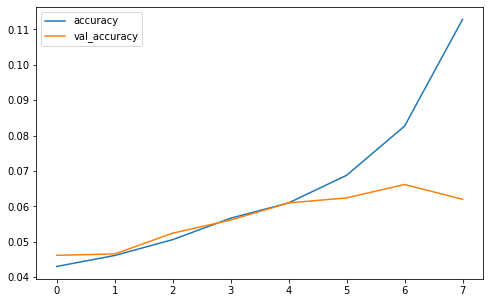

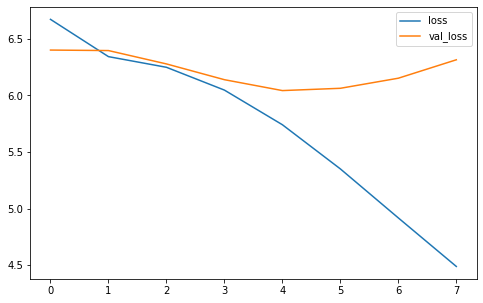

In [ ]:
# Evaluate the model
accuracy = trained_model.history['accuracy']
val_accuracy = trained_model.history['val_accuracy']
loss = trained_model.history['loss']
val_loss = trained_model.history['val_loss']
pd.DataFrame({'accuracy': accuracy, 'val_accuracy': val_accuracy}).plot(figsize=(8,5))
pd.DataFrame({'loss': loss, 'val_loss': val_loss}).plot(figsize=(8,5))

#### **Text Generation**

In [ ]:
# State the Trigger (Seed) Text
seed_text = 'christmas is not christmas \ntill cakes men are baked \nchristmas trees are decorated \nand every one is loved \ni do not want a lot for christmas n\there is just one thing i need \nI do not care about those presents \nunderneath the christmas tree \ni just want you for my own \nmore than you could ever know'
len(seed_text.split())

58

In [ ]:
def texts_to_sequences(texts, word_to_index):
    indices = np.zeros((1, len(texts)), dtype=int)
    for i, text in enumerate(texts):
        indices[:, i] = word_to_index[text]
    return indices
def my_pad_sequences(seq, maxlen):
    start = seq.shape[1] - maxlen
    return seq[:, start: start + maxlen]

n_words = 100 #generating 50 characters after initial sequence
result = list()
in_text = seed_text

for _ in range(n_words):
    encoded = texts_to_sequences(in_text.split()[1:], word_to_index)
    encoded = my_pad_sequences(encoded, maxlen=seq_length)
    yhat = model.predict_classes(encoded, verbose=1)
    out_word = ''
    for word, index in word_to_index.items():
        if index == yhat:
            out_word = word
            break
    in_text += ' ' + out_word
    result.append(out_word)

# Print the Lyrics
print(in_text)

1/1 [==============================] - 0s 37ms/step
christmas is not christmas 
till cakes men are baked 
christmas trees are decorated 
and every one is loved 
i do not want a lot for christmas n	here is just one thing i need 
I do not care about those presents 
underneath the christmas tree 
i just want you for my own 
more than you could ever know you you want want want want want want want want my my want want want want want want want want want want want want want want want want want want i i i i i i i i i i i i i i i i i i i i wish wish wish wish wish wish i i i i i i i i na na na na na na na na na na na na na na na na na na na na na na na na na na na na na na na na na na oh oh


### **2.RNN CharModel**

#### **Data Preparation**

In [ ]:
# We will read in all of the cleaned lyrics into a single text file for training
with open('lyricsText.txt', 'w', encoding='utf-8') as filehandle:
  for listitem in new_df['Cleaned Lyrics']:
    filehandle.write('%s\n' % listitem)
textFileName = 'lyricsText.txt'
lyricsText = open(textFileName, encoding = 'UTF-8').read()

# Set the vocabulary for all the lyrics 
chars = sorted(list(set(lyricsText)))
int_chars = dict((i, c) for i, c in enumerate(chars))
chars_int = dict((i, c) for c, i in enumerate(chars))
n_chars = len(lyricsText)
n_vocab = len(chars)
print('Number of Characters : ' , n_chars)
print('Number of Alphabet : ', n_vocab) 
print(int_chars)

# Set a specific window 
# Define couple of predictor-target for the model 
seq_len = 100 #Inputs of the model will be sequences of 100 characters
data_X = [] #initializing an empty list data_X that will store sequences of 100 characters
data_y = [] #initializing an empty list data_y that will store targets of data_X
for i in range(0, n_chars - seq_len, 1): #looping from 1 to number of sequences of length 100 in raw_text
    seq_in  = lyricsText[i:i+seq_len] #taking a sequence of length 100 from raw_text
    seq_out = lyricsText[i + seq_len] #taking the character that follows the sequence
    data_X.append([chars_int[char] for char in seq_in]) #mapping seq_in to integers and append it to data_X
    data_y.append(chars_int[seq_out]) #mapping the seq_out to integer and append it to data_y
n_patterns = len(data_X)
print( 'Total Patterns : ', n_patterns)#number of samples
print( 'Total number of sequences : ', len(data_X))

# Normalize predictor and categorize target
X = np.reshape(data_X , (n_patterns, seq_len, 1))
X = X/ float(n_vocab)
y = np_utils.to_categorical(data_y)
np.unique(data_y)

# Split the dataset
X,X_test,y,y_test=train_test_split(X,y,random_state=42)
print(len(data_X)) #total number of samples before split
print(len(X)) #number of samples used in training(75%)
print(len(X_test)) #number of samples used in testing(25%)

Number of Characters :  526075
Number of Alphabet :  64
{0: '\n', 1: ' ', 2: '"', 3: '#', 4: '&', 5: "'", 6: '*', 7: '+', 8: '-', 9: '/', 10: '0', 11: '1', 12: '2', 13: '3', 14: '4', 15: '5', 16: '6', 17: '7', 18: '8', 19: '9', 20: 'I', 21: '[', 22: ']', 23: 'a', 24: 'b', 25: 'c', 26: 'd', 27: 'e', 28: 'f', 29: 'g', 30: 'h', 31: 'i', 32: 'j', 33: 'k', 34: 'l', 35: 'm', 36: 'n', 37: 'o', 38: 'p', 39: 'q', 40: 'r', 41: 's', 42: 't', 43: 'u', 44: 'v', 45: 'w', 46: 'x', 47: 'y', 48: 'z', 49: '{', 50: '}', 51: 'á', 52: 'é', 53: 'ñ', 54: 'ó', 55: 'ö', 56: '\u2005', 57: '–', 58: '—', 59: '‘', 60: '’', 61: '“', 62: '”', 63: '\u205f'}
Total Patterns :  525975
Total number of sequences :  525975
525975
394481
131494


#### **Model Implementation**

In [ ]:
# Define the model
model = Sequential() #defining a sequential model
model.add(LSTM(256, input_shape =(X.shape[1], X.shape[2]), return_sequences = True)) #add an LSTM layer as input layer
model.add(Dropout(0.2))
model.add(LSTM(256, return_sequences=True)) # We add three LSTM layers as hidden layers with 256 nodesin each layer
model.add(LSTM(256, return_sequences=True))
model.add(LSTM(256, return_sequences=True))
model.add(Flatten()) #We flatten the data that is coming from the last hidden layer to input it to the output layer
model.add(Dense(n_vocab, activation = 'softmax')) #We add a dense which is a fully connected neural network layer where each input node is connected to each output node #We also add an activation layer that determines activation function our neural network will use to calculate the output of a node.Since it's a multiclassification problem ,we use softmax function.

model.compile(loss='categorical_crossentropy', #Now we compile our model .Since it's a multiclassification problem ,we calculate the loss for each iteration of the training by using categorical cross entropy and optimise our network by using 'adam' optimizer .
              optimizer='adam', 
              metrics=['accuracy'])


#We can see a summary of our model
model.summary()
#keras.utils.plot_model(model)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 100, 256)          264192    
_________________________________________________________________
dropout_5 (Dropout)          (None, 100, 256)          0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 100, 256)          525312    
_________________________________________________________________
lstm_17 (LSTM)               (None, 100, 256)          525312    
_________________________________________________________________
lstm_18 (LSTM)               (None, 100, 256)          525312    
_________________________________________________________________
flatten_5 (Flatten)          (None, 25600)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)               

In [ ]:
# TRAIN THE MODEL
#To avoid loosing our work ,we use model checkpoints so that the weights of the network nodes are saved to a file after every epoch.
checkpoint_path = "/content/gdrive/My Drive/model_char/weights-{epoch:02d}-{loss:.5f}.hdf5"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='loss', verbose = 1, save_best_only = True, mode ='min')
history = History()
earlystopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
callbacks_list = [checkpoint, history, earlystopping]
np.random.seed(42) #to obtain same results everytime we run code

#training the model with parameters indicated in model_params
model_params = {'epochs':50, # number of complete passes through the training dataset
                'batch_size':512, # number of samples processed before the model is updated
                'callbacks':callbacks_list, 
                'verbose':1,
                'validation_split':0.2,
                'shuffle': True,
                'initial_epoch':0}
trained_model = model.fit(X,
                          y,
                          epochs = model_params['epochs'],
                          batch_size = model_params['batch_size'],
                          callbacks= model_params['callbacks'],
                          verbose = model_params['verbose'],
                          validation_split = model_params['validation_split'],
                          shuffle = model_params['shuffle'],
                          initial_epoch = model_params['initial_epoch'])

Train on 315584 samples, validate on 78897 samples
Epoch 1/50
315584/315584 [==============================] - 298s 945us/step - loss: 3.0243 - accuracy: 0.1580 - val_loss: 3.0194 - val_accuracy: 0.1568

Epoch 00001: loss improved from inf to 3.02434, saving model to /content/gdrive/My Drive/model_char/weights-01-3.02434.hdf5
Epoch 2/50
315584/315584 [==============================] - 303s 961us/step - loss: 3.0150 - accuracy: 0.1583 - val_loss: 3.0207 - val_accuracy: 0.1568

Epoch 00002: loss improved from 3.02434 to 3.01500, saving model to /content/gdrive/My Drive/model_char/weights-02-3.01500.hdf5
Epoch 3/50
315584/315584 [==============================] - 296s 938us/step - loss: 3.0138 - accuracy: 0.1583 - val_loss: 3.0188 - val_accuracy: 0.1568

Epoch 00003: loss improved from 3.01500 to 3.01377, saving model to /content/gdrive/My Drive/model_char/weights-03-3.01377.hdf5
Epoch 4/50
315584/315584 [==============================] - 298s 944us/step - loss: 2.9327 - accuracy: 0.1746 

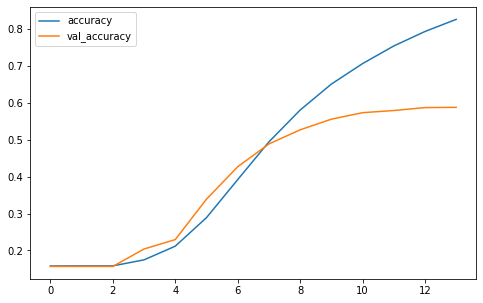

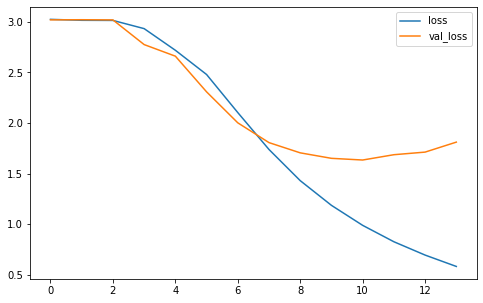

In [ ]:
# Evaluate the model
accuracy = trained_model.history['accuracy']
val_accuracy = trained_model.history['val_accuracy']
loss = trained_model.history['loss']
val_loss = trained_model.history['val_loss']
pd.DataFrame({'accuracy': accuracy, 'val_accuracy': val_accuracy}).plot(figsize=(8,5))
pd.DataFrame({'loss': loss, 'val_loss': val_loss}).plot(figsize=(8,5))

#### **Text Generation**

In [ ]:
# State the Trigger (Seed) Text
seed_text = 'christmas is not christmas \ntill cakes men are baked \nchristmas trees are decorated \nand every one is loved \ni do not want a lot for christmas n\there is just one thing i need \nI do not care about those presents \nunderneath the christmas tree \ni just want you for my own \nmore than you could ever know'
len(seed_text.split())
pattern = [chars_int[char] for char in seq_in]

#start = np.random.randint(0, len(data_X)-1)#Returning a random number
#pattern = data_X[start]#we pick a random index in the list as our starting point
# print('Seed : ')
# print("\"",''.join([int_chars[value] for value in pattern]), "\"\n")

In [ ]:
generated_characters = 500 #generating 500 characters after initial sequence

for i in range(generated_characters):
    x = np.reshape(pattern, ( 1, len(pattern), 1))#We reshape the sequence x
    x = x / float(n_vocab)#We normalize it
    prediction = model.predict(x,verbose = 0)#We calculate the probability of each class to follow this sequence
    index = np.argmax(prediction)#We detect the index of the highest probability
    result = int_chars[index]#We map integer to character
    sys.stdout.write(result)#we display the character(result of the prediction)
    pattern.append(index)#We append this character to the sequence
    pattern = pattern[1:len(pattern)]#We remove the first character of the sequence to obtain a new sequence and repeat the same process until predicting 500 characters.
print('\nDone')


and eo saies
lare
the soeeies the might we ail shis kas it was a druld fere it da kasgis' tanta wes a christmas with mooe eoieaay
oo shnw ler't bat i ione to sime to mev's aeen christmas it aow
and ginleo' bround the children our children ahatsonnh
panpa'claus iave a happy how christmas
iv's bhristmas iillle all the card ala molk sie ppel asid
trieeas the world js heest wour pame wooese's mo nerry christmas with moo
christmas tree nan
[bhorus]
she dhildren ow we don't want a pong po the ginl an
Done


### **3.Textgenrnn Model**

#### **Data Preparation**

In [ ]:
# We will read in all of the cleaned lyrics into a single text file for training
with open('lyricsText.txt', 'w', encoding='utf-8') as filehandle:
  for listitem in new_df['Cleaned Lyrics']:
    filehandle.write('%s\n' % listitem)
textFileName = 'lyricsText.txt'
raw_text = open(textFileName, encoding = 'UTF-8').read()
raw_text

'hey ho nobody home\nmeat nor drink nor money have I none\nyet shall we be merry\nhey ho nobody home\nnan\nhey ho nobody home\nmeat nor drink nor money have I none\nyet shall we be merry\nhey ho nobody home\nhey ho nobody home\nnan\nsoal a soal a soal cake please good missus a soul cake\nan apple a pear a plum a cherry\nany good thing to make us all merry\none for peter two for paul three for him who made us all\nnan\ngod bless the master of this house and the mistress also\nand all the little children that round your table grow\nthe cattle in your stable the dog by your front door\nand all that dwell within your gates we wish you ten times more\nnan\nsoal a soal a soal cake please good missus a soul cake\nan apple a pear a plum a cherry\nany good thing to make us all merry\none for peter two for paul three for him who made us all\nnan\ngo down into the cellar and see what you can find\nif the barrels are not empty we hope you will be kind\nwe hope you will be kind with your apple and 

#### **Model Implementation**

In [ ]:
text_file = 'lyricsText.txt'
model_name = '500nds_12Lrs_100epchs_Model'
textgen = textgenrnn(name=model_name)
print(textgen.model.summary())

model_cfg = {
    'rnn_size': 128, # number of LSTM cells of each layer (128/256 recommended)
    'rnn_layers': 4, # number of LSTM layers (>=2 recommended)
    'rnn_bidirectional': True, # consider text both forwards and backward, can give a training boost
    'max_length': 40, # number of tokens to consider before predicting the next (20-40 for characters, 5-10 for words recommended)
    'max_words': False,  # maximum number of words to model; the rest will be ignored (word-level model only)
    'dim_embeddings': 100,
    'word_level': True # set to True if want to train a word-level model (requires more data and smaller max_length)
    }

train_cfg = {
    'line_delimited': True,  # set to True if each text has its own line in the source file
    'num_epochs': 20, # set higher to train the model for longer
    'gen_epochs': 2, # generates sample text from model after given number of epochs
    'batch_size': 1024, # proportion of input data to train on: setting < 1.0 limits model from learning perfectly
    'train_size': 0.8, # ignore a random proportion of source tokens each epoch, allowing model to generalize better
    'dropout': 0.2, # If train__size < 1.0, test on holdout dataset; will make overall training slower
    'max_gen_length': 300,
    'validation': True,
    'is_csv': False # set to True if file is a CSV exported from Excel/BigQuery/pandas
}


train_function = textgen.train_from_file if train_cfg['line_delimited'] else textgen.train_from_largetext_file
train_function(
    file_path=text_file,
    new_model=True,
    num_epochs=train_cfg['num_epochs'],
    gen_epochs=train_cfg['gen_epochs'],
    batch_size=train_cfg['batch_size'],
    train_size=train_cfg['train_size'],
    dropout=train_cfg['dropout'],
    max_gen_length=train_cfg['max_gen_length'],
    validation=train_cfg['validation'],
    is_csv=train_cfg['is_csv'],
    rnn_layers=model_cfg['rnn_layers'],
    rnn_size=model_cfg['rnn_size'],
    rnn_bidirectional=model_cfg['rnn_bidirectional'],
    max_length=model_cfg['max_length'],
    dim_embeddings=model_cfg['dim_embeddings'],
    word_level=model_cfg['word_level'])

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 40)           0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 100)      46500       input[0][0]                      
__________________________________________________________________________________________________
rnn_1 (CuDNNLSTM)               (None, 40, 128)      117760      embedding[0][0]                  
__________________________________________________________________________________________________
rnn_2 (CuDNNLSTM)               (None, 40, 128)      132096      rnn_1[0][0]                      
____________________________________________________________________________________________

In [ ]:
#Download Model Parameters
files.download('{}_weights.hdf5'.format(model_name))
files.download('{}_vocab.json'.format(model_name))
files.download('{}_config.json'.format(model_name))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### **Text Generation**

In [ ]:
weights_path = '{}_weights.hdf5'.format(model_name)
vocab_path = '{}_vocab.json'.format(model_name)
config_path = '{}_config.json'.format(model_name)
textgen = textgenrnn(weights_path=weights_path,
                     vocab_path=vocab_path,
                     config_path=config_path  
                     )
generated_characters = 300
text = textgen.generate(n=100, max_gen_length= 100, top_n=3)

[ verse 1 ]

nan

nan

nan

but i ' ma be under the mistletoe

nan

[ verse 1 ]

nan

nan

oh comin ' home

i ' ll still come home for christmas

nan

make my wish come true

the pretty paper pretty ribbons of blue

it ' s just another new year ' s eve

and the bells are ringing

nan

i ' ll be dropping by today

[ verse 2 ]

it ' s christmas time

nan

and i ' m missing all

nan

i want an alien for christmas this year

nan

i don ' t want a lot for christmas

nan

nan

nan

with every hope and every dream

[ chorus ]

[ pre - chorus ]

it ' s the most wonderful time of the year

nan

nan

i ' ll be home with my love this christmas i ' ll be home

i ' ve got to go away

and i ' ve brought some corn for popping

when we finally kiss goodnight

i ' ll give it to someone special special

oh by gosh by golly

i ' m gonna tick tick tick on the luckiest man

it ' s the most wonderful time of the year

i ' m so happy

nan

the ones that you love make sure they know it

ooh ooh ooh ooh

i ' l

### **4.GPT-2 Model**

In [ ]:
!pip install -q gpt-2-simple
import gpt_2_simple as gpt2
!nvidia-smi

In [ ]:
# We will read in all of the cleaned lyrics into a single text file for training
with open('lyricsText.txt', 'w', encoding='utf-8') as filehandle:
  for listitem in new_df['Cleaned Lyrics']:
    filehandle.write('%s\n' % listitem)
textFileName = 'lyricsText.txt'

In [ ]:
gpt2.download_gpt2(model_name="355M")
gpt2.mount_gdrive()

Fetching checkpoint: 1.05Mit [00:00, 469Mit/s]                                                      
Fetching encoder.json: 1.05Mit [00:00, 133Mit/s]                                                    
Fetching hparams.json: 1.05Mit [00:00, 727Mit/s]                                                    
Fetching model.ckpt.data-00000-of-00001: 1.42Git [00:07, 182Mit/s]                                  
Fetching model.ckpt.index: 1.05Mit [00:00, 398Mit/s]                                                
Fetching model.ckpt.meta: 1.05Mit [00:00, 129Mit/s]                                                 
Fetching vocab.bpe: 1.05Mit [00:00, 163Mit/s]                                                       


Mounted at /content/drive


In [ ]:
file_name = "lyricsText.txt"
sess = gpt2.start_tf_sess()
gpt2.finetune(sess,
              dataset=file_name,
              model_name='355M',
              steps=1000,
              restore_from='fresh',
              run_name='run1',
              print_every=10,
              sample_every=200,
              save_every=500,
              )

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Please use tensorflow.python.ops.op_selector.get_backward_walk_ops.
Loading checkpoint models/355M/model.ckpt
INFO:tensorflow:Restoring parameters from models/355M/model.ckpt


  0%|          | 0/1 [00:00<?, ?it/s]

Loading dataset...


100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


dataset has 145418 tokens
Training...
[10 | 24.12] loss=2.32 avg=2.32
[20 | 41.09] loss=2.92 avg=2.62
[30 | 57.48] loss=2.25 avg=2.50
[40 | 73.71] loss=2.75 avg=2.56
[50 | 90.02] loss=2.27 avg=2.50
[60 | 106.49] loss=2.20 avg=2.45
[70 | 123.06] loss=1.51 avg=2.31
[80 | 139.47] loss=2.37 avg=2.32
[90 | 155.78] loss=2.30 avg=2.32
[100 | 172.13] loss=1.88 avg=2.27
[110 | 188.53] loss=2.15 avg=2.26
[120 | 204.94] loss=2.69 avg=2.30
[130 | 221.34] loss=1.96 avg=2.27
[140 | 237.72] loss=1.59 avg=2.22
[150 | 254.12] loss=1.49 avg=2.17
[160 | 270.55] loss=1.05 avg=2.09
[170 | 287.01] loss=1.38 avg=2.05
[180 | 303.46] loss=1.72 avg=2.03
[190 | 319.86] loss=1.21 avg=1.98
[200 | 336.24] loss=2.44 avg=2.00
======== SAMPLE 1 ========
 plan
nan
[verse 2 jessica]
what's this smell
you smell
what's that in the air
we've got to do this together
it's gonna be ok
it's gonna be ok
it's gonna be ok
it's gonna be ok
it's gonna be ok
the snowman
the santa claus
nan
[chorus jessica]
it's gonna be ok
it's gonn

In [ ]:
gpt2.copy_checkpoint_to_gdrive(run_name='run1') #save checkpoints to drive
gpt2.copy_checkpoint_from_gdrive(run_name='run1') #import checkpoints to drive
sess = gpt2.start_tf_sess() #start a empty session
gpt2.load_gpt2(sess, run_name='run1') #load session

In [ ]:
gpt2.generate(sess,
              length=250,
              temperature=0.7,
              prefix="Christmas ain't Christmas \ntill gingerbread men are baked \nChristmas trees are decoreted \nand every one is loved",
              nsamples=5,
              batch_size=5
              )

Christmas ain't Christmas 
till gingerbread men are baked 
Christmas trees are decoreted 
and every one is loved
santa's coming for us
nan
[interlude]
merry christmas baby
merry christmas baby
may your every new year dream come true
nan
[verse 2]
oh christmas morning I got up and dialed the phone
i made a few arrangements at the county children's home
and they told me it would be alright to pick her up today
now christmas morning I woke up and her was gone
oh christmas morning I got up and dialed the phone
i made a few arrangements at the county children's home
and they told me it would be alright to pick her up today
merry christmas baby merry christmas
merry christmas baby merry christmas
may your every new year dream come true
merry christmas baby merry christmas
may your every new year dream come true
nan
[verse 3]
oh I know you're out there somewhere
taking in the sunshine while your tree is glowing
or maybe you could come home for christmas
where as we sit here waiting for you to